<h1 style='color:purple' align='center'>Employee Retention Project</h1> 

- left (dependent/output var) : 1 / left , 0 / stayed
- empid: employee ID 
- satisfaction_level : satisfaction range of an employee between 0 and 1
- last_evaluation : Time since last performance evaluation (in years)
- number_project : Number of projects complated while at work
- average_montly_hours: AMH at the workplace
- time_spend_company : number of years spent in company
- Work_accident : whether the employee had a workplace accident(1) or not(0)
- promotion_last_5years : whether the employee was promoted in five years(1) or not(0)
- salary : Relative level of salary (low, medium, high)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv # for quick EDA
import warnings
warnings.filterwarnings('ignore')

## Exploratory Analysis

In [3]:
data = pd.read_csv("hr_employee_churn_data.csv")

In [4]:
data.head()

empid  satisfaction_level  last_evaluation  number_project  \
0      1                0.38             0.53               2   
1      2                0.80             0.86               5   
2      3                0.11             0.88               7   
3      4                0.72             0.87               5   
4      5                0.37             0.52               2   

   average_montly_hours  time_spend_company  Work_accident  \
0                   157                   3              0   
1                   262                   6              0   
2                   272                   4              0   
3                   223                   5              0   
4                   159                   3              0   

   promotion_last_5years  salary  left  
0                      0     low     1  
1                      0  medium     1  
2                      0  medium     1  
3                      0     low     1  
4                      0     low     1

In [4]:
#10 cols, 14999 rows.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


In [31]:
# you can see statistical distribution and measurements of each observations in practical way with SWEETVIZ
analyze_report = sv.analyze(data)
analyze_report.show_html('analyze.html',open_browser=True) # also check your work directory for anaylze.html file.

                                             |                                             | [  0%]   00:00 ->…

Report analyze.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


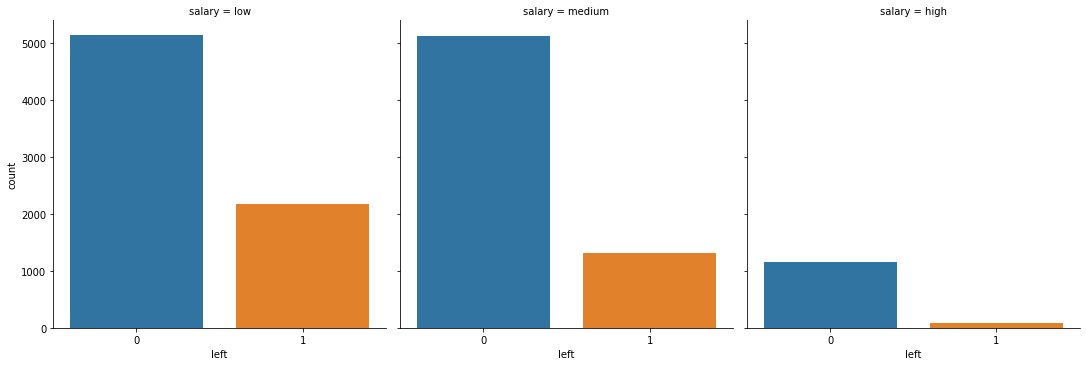

In [18]:
sns.catplot(x='left', col='salary', kind='count', data=data);

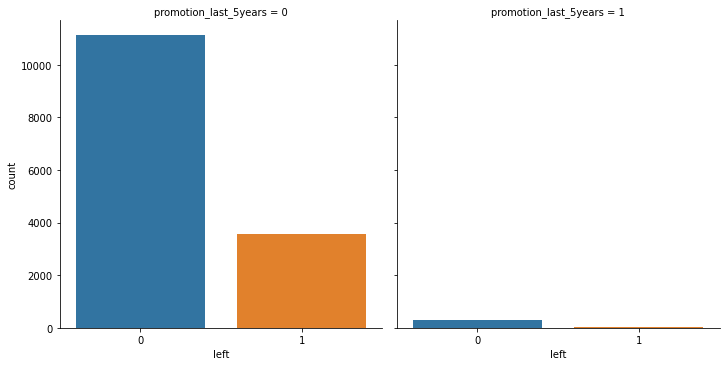

In [17]:
sns.catplot(x='left', col='promotion_last_5years', kind='count', data=data);

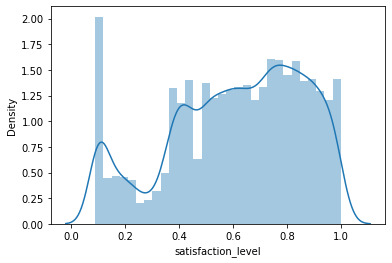

In [57]:
sns.distplot(data['satisfaction_level']);
#satisfaction level 0.1 has high at 0.1 

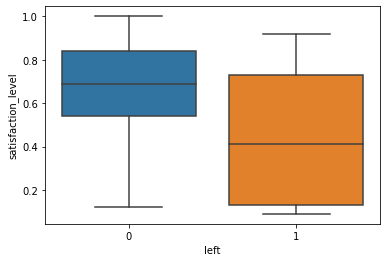

In [23]:
sns.boxplot(x='left', y='satisfaction_level', data=data);

<AxesSubplot:>

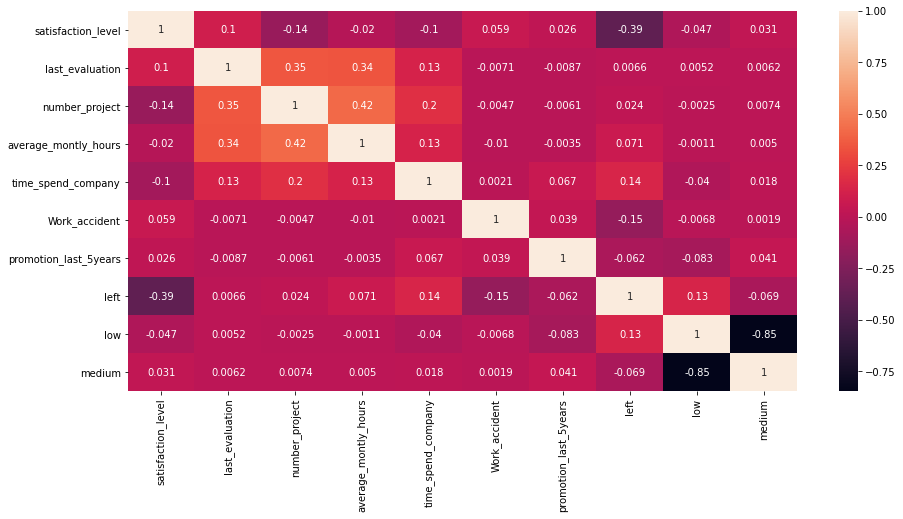

In [24]:
#checking for correlations
corr_mat = df.corr()
fig = plt.figure(figsize = (15,7))
sns.heatmap(corr_mat, annot=True)

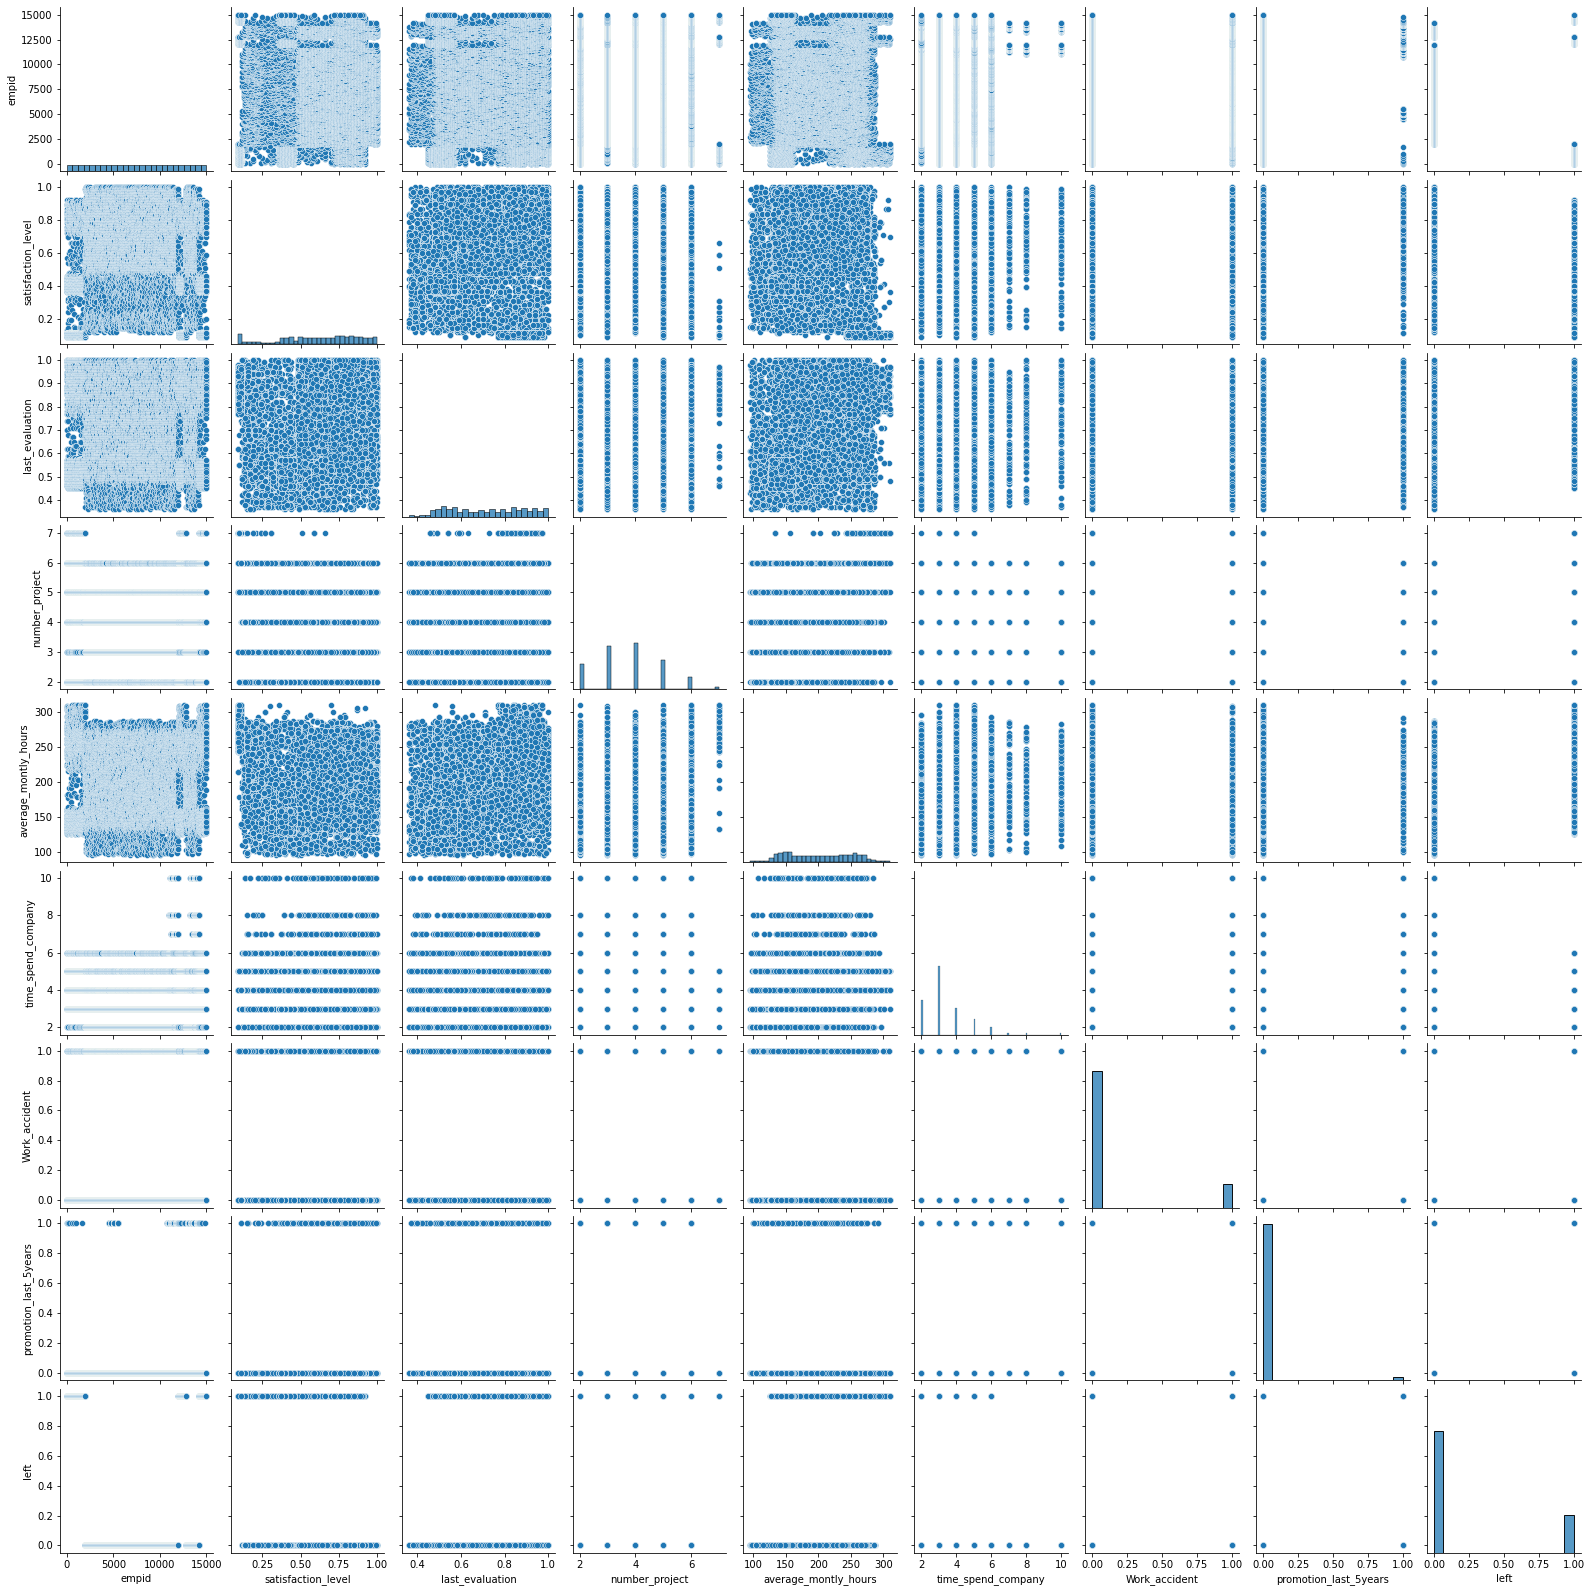

In [25]:
sns.pairplot(data); 

## Feature Engineering

In [5]:
df = data.copy()
df.drop('empid', axis = 1,inplace=True)

In [6]:
df.isnull().sum() 

satisfaction_level       2
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

In [7]:
df.satisfaction_level.describe().T

count    14997.000000
mean         0.612863
std          0.248634
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [8]:
#filling the missing values with mean : 0.64 
df['satisfaction_level'].fillna(df['satisfaction_level'].mean(),inplace=True)

In [9]:
#handle the categorical values of salary col
salary_dummies = pd.get_dummies(df['salary'],drop_first=True)
df = pd.concat([df,salary_dummies], axis=1)
df = df.drop('salary',axis=1)

In [65]:
df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  left  low  medium  
0                   3              0                      0     1    1       0  
1                   6              0                      0     1    0       1  
2                   4              0                      0     1    0       1  
3                   5              0                      0     1    1       0  
4                   3              0                      0     1    1       0

## Train-Test Split

In [10]:
X = df.drop('left',axis=1)
y= df['left']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [12]:
len(X_train)

11999

In [13]:
len(X_test)

3000

## Model Selection

In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [46]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'RandomForestClassifier' : {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['gini', 'entropy'],
                'max_depth': range(2,4,1),
                'max_features': ['auto', 'log2'] 
            }
        },
        'XGBClassifier': {
            'model': XGBClassifier(objective='binary:logistic', verbosity = 0, random_state=1),
            'params': {
                'n_estimators': [10, 50, 100, 200],
                'max_depth':  [3, 5, 10, 20],
                'learning_rate': [0.5, 0.1, 0.01, 0.05 ]
            }
        }
    }
    
    scores = []
    for algo_name, config in algos.items():
        model_selection =  GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False)
        model_selection.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': model_selection.best_score_,
            'best_params': model_selection.best_params_
        })
         
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [47]:
outcome = find_best_model_using_gridsearchcv(X,y)

In [48]:
outcome #XGBoost gives best result, so I'll use that algo with its finding best parameters.

model  best_score  \
0  RandomForestClassifier    0.924797   
1           XGBClassifier    0.990266   

                                         best_params  
0  {'criterion': 'gini', 'max_depth': 3, 'max_fea...  
1  {'learning_rate': 0.1, 'max_depth': 20, 'n_est...

In [49]:
outcome['best_params'].iloc[1]

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}

## Model Building 

In [18]:
# Model training
model_xgb = XGBClassifier(objective='binary:logistic',learning_rate= 0.1, max_depth= 20, n_estimators= 200, verbosity = 0, random_state=1)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [19]:
# Model Testing
model_xgb.score(X_test,y_test) 

0.9923333333333333

In [20]:
X_test.head()

satisfaction_level  last_evaluation  number_project  \
1670                 0.44             0.57               2   
13378                0.55             0.96               3   
10233                0.72             0.67               5   
4719                 0.96             0.75               4   
7003                 0.96             0.54               3   

       average_montly_hours  time_spend_company  Work_accident  \
1670                    141                   3              0   
13378                   194                   3              0   
10233                   210                   2              0   
4719                    177                   2              0   
7003                    198                   3              0   

       promotion_last_5years  low  medium  
1670                       0    0       1  
13378                      0    0       1  
10233                      0    0       1  
4719                       0    1       0  
7003                       0    1       0

In [21]:
X_test[:1]

satisfaction_level  last_evaluation  number_project  \
1670                0.44             0.57               2   

      average_montly_hours  time_spend_company  Work_accident  \
1670                   141                   3              0   

      promotion_last_5years  low  medium  
1670                      0    0       1

In [22]:
#predict for first row
model_xgb.predict(X_test[:1]) #left: 1

array([1], dtype=int64)

In [23]:
y_test[:1]

1670    1
Name: left, dtype: int64

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model_xgb.predict(X_test))
cm

array([[2292,    7],
       [  16,  685]], dtype=int64)

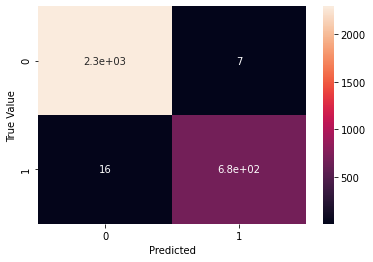

In [25]:
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()